<a href="https://colab.research.google.com/github/PayalSahrma/Course/blob/master/Aircraft_Predictive_Maintenance_Case_Study_using_RNN%2B(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
Predict if an engine will fail within a particular cycle, given its history of cycles and sensory data.

### Objective

* Aircraft are very sensitive to the faults in their engines.

* Because of this, it is imperative to keep them in good condition for the safety of the passengers.

* Aircraft are very expensive and so is their maintenance.

* But at the same time, we do not want to overdo the maintenance aspect.

* If we do not detect a fault in time, it might become too expensive to maintain/repair the engines, or they might have to be replaced


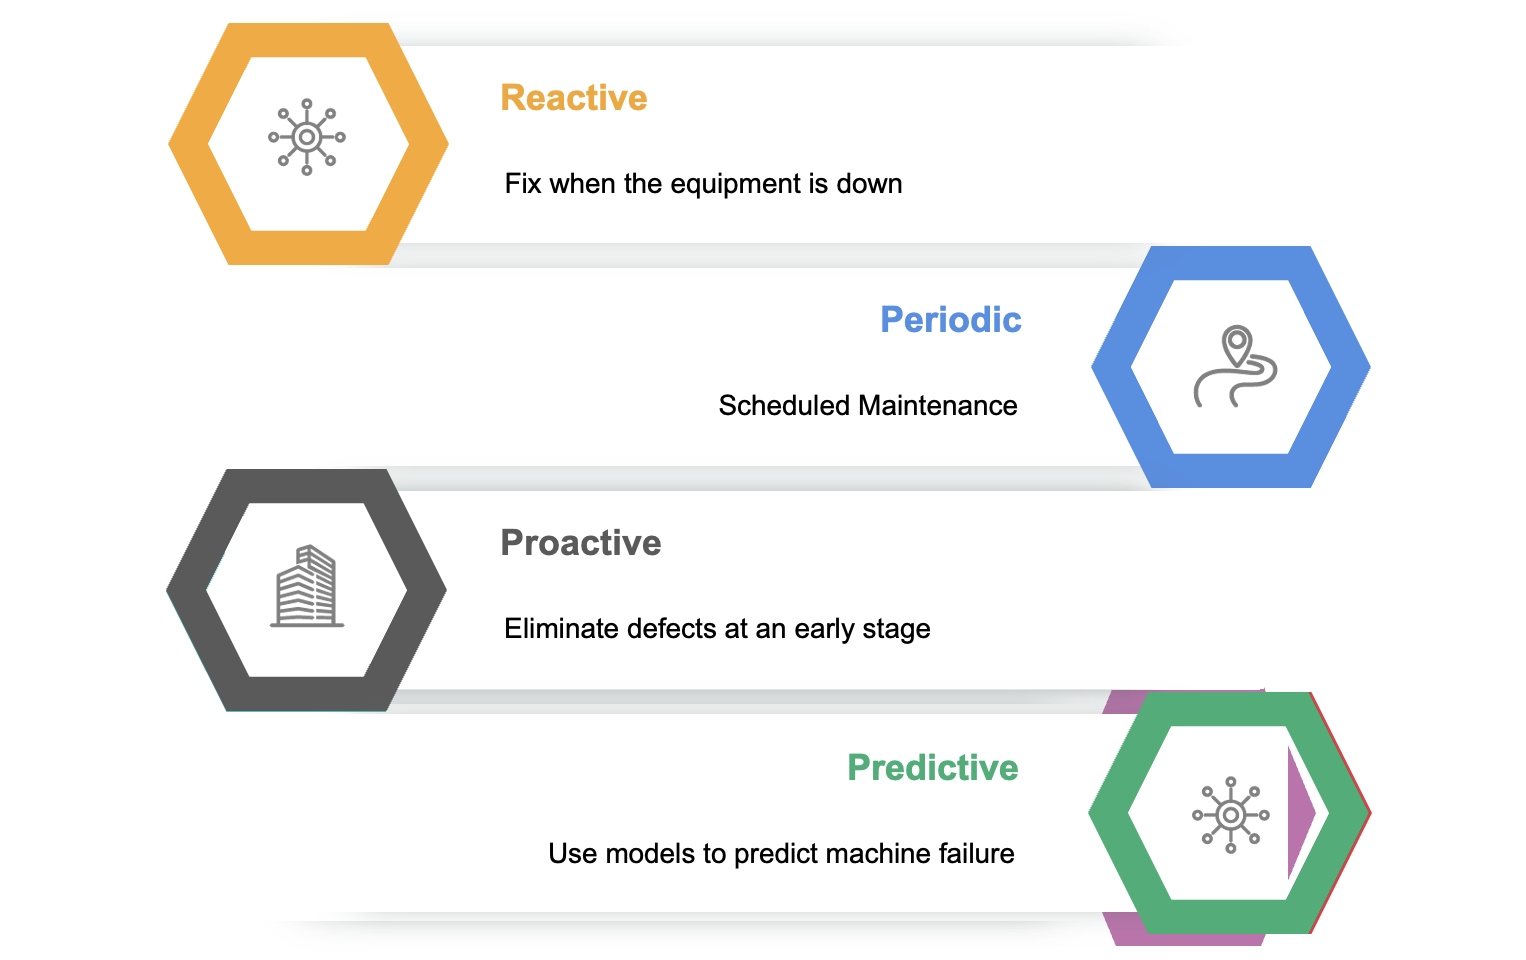

# Loading Datasets and Libraries

### Import Libraries

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [ ]:
# We will set the seed for reproducibility.
np.random.seed(1234)
PYTHONHASHSEED = 0

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN

### Load the Dataset

Download the datasets from Azure:


1. Training data
2. Test data
3. Truth label for the test data


We downloaded the Azure data set using the wget command.

In [ ]:
# Data ingestion - reading the data sets from the Azure blob
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2022-12-26 17:57:05--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.237.69, 13.107.238.69, 2620:1ec:4e:1::69, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.237.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt’

PM_train.txt        100%[===================>]   3.35M  7.56MB/s    in 0.4s    

2022-12-26 17:57:06 (7.56 MB/s) - ‘PM_train.txt’ saved [3515356/3515356]

--2022-12-26 17:57:06--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.237.69, 13.107.238.69, 2620:1ec:4e:1::69, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.237.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt’

PM_test.t

Load the data set into the DataFrame and name the columns/features.

[read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) is used to load .csv files into a Pandas DataFrame. The separator is space(" "), as used in the data set, and the header=None is used to specify that the header is absent.

In [ ]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


Let's drop the NAN columns 26 and 27 using the [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, where axis=1 indicates that **NAN** columns are to be dropped, and inplace=True indicates that the operation will change the original array in place.

In [ ]:
# The last two columns are not real.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [ ]:
f = open('PM_train.txt',"r")
content = f.read()

ff = open('maintain_log.txt',"w+")
ff.write(f.read())

f.close()

Let's name the columns as per the data definition given on Azure’s website.

In [ ]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Load the ground truth for the test data, which indicates the remaining useful cycles for the engines.

In [ ]:
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [ ]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)

# Data Preprocessing

We will do the following while preprocessing the training dataset:

1. Generating the classification target variable
2. Normalizing the data set
3. Performing some EDA
4. Generating input sequences
5. Generating a sequence label


### Generating Classification Target Variable
We will classify the cycles close to breakdown with their respective ids as 1 in the target variable failure_within_w1.

Here, w1 signifies the window_1, which in this case is 30.



As we are interested in a classification problem, we will label the data according to our problem statement using the NumPy [where()](https://numpy.org/doc/stable/reference/generated/numpy.where.html) function.

**Calculate 'failure_within-w1'**

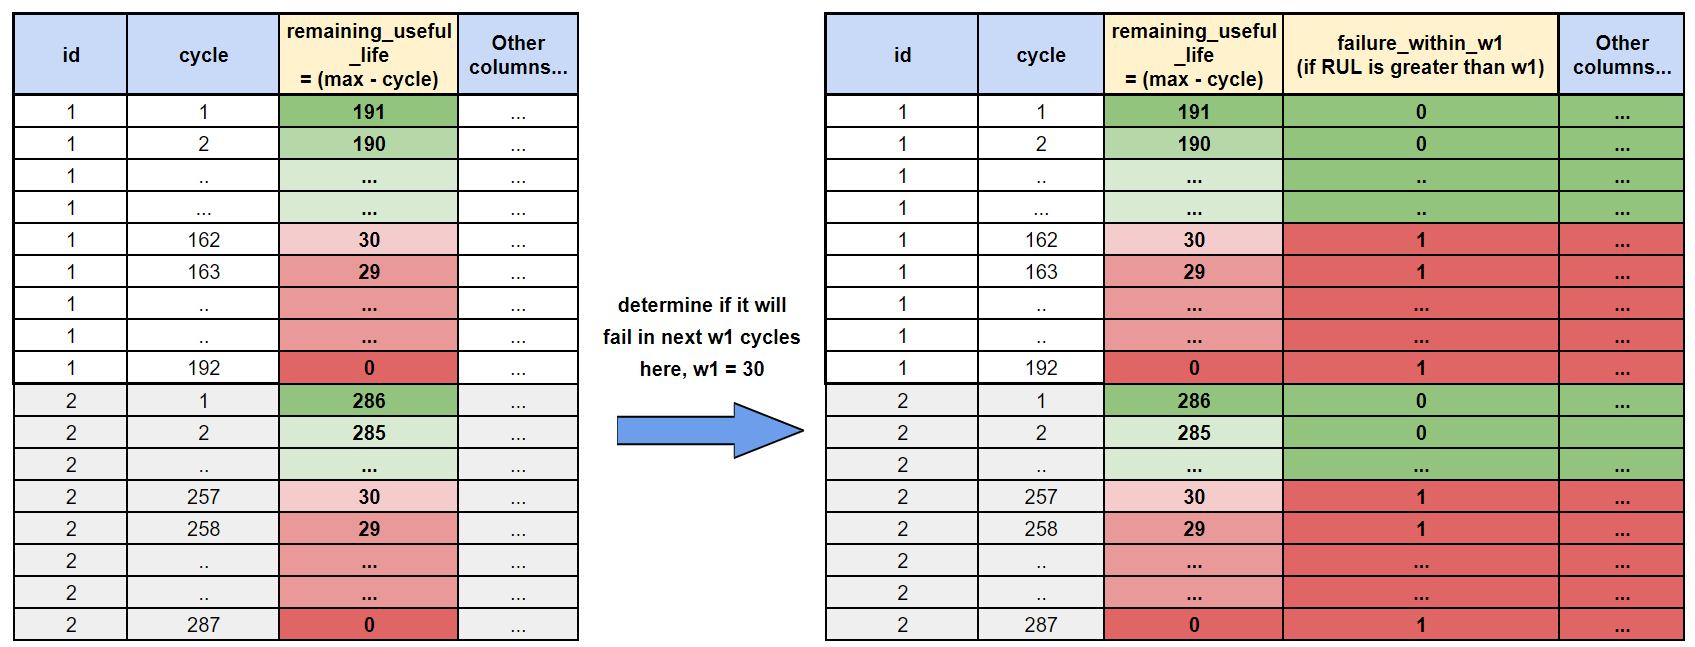

Sort the data set by id and cycles so each engine can have its values sorted and stored in one place. We use the [sort_values()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) method and specify which columns are to be considered while sorting using the parameter.

In [ ]:
train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

First, we find the maximum cycles observed for each engine using [groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and then merge these values for respective engine data using [merge()](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).

Then, we calculate the remaining useful life (RUL) by subtracting the current cycle value from the max. For example, a cycle has a total life of 192 cycles, and it has already run 50 cycles; hence, its RUL will be 192-50 = 142.

In [ ]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles)  to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [ ]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

**Generate label column for training data**

In [ ]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

### Normalize Training Dataset

While normalizing the training data set, we do not want to consider some columns. We exclude these columns using [difference()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.difference.html).

Then, we normalize the values between 0 and 1 using [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and then join it with the columns we excluded previously using [join()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html). [Reindex()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reindex.html) is used to reindex the index of the data set, starting from 0.

In [ ]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


Normalize the test data in the same manner that you normalized the training data.

In [ ]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

Label the test set like we did for the training data.

In [ ]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )

In [ ]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


### Exploratory Data Analysis - EDA

Let's see how the sensor values change for a particular engine id, say id=1.

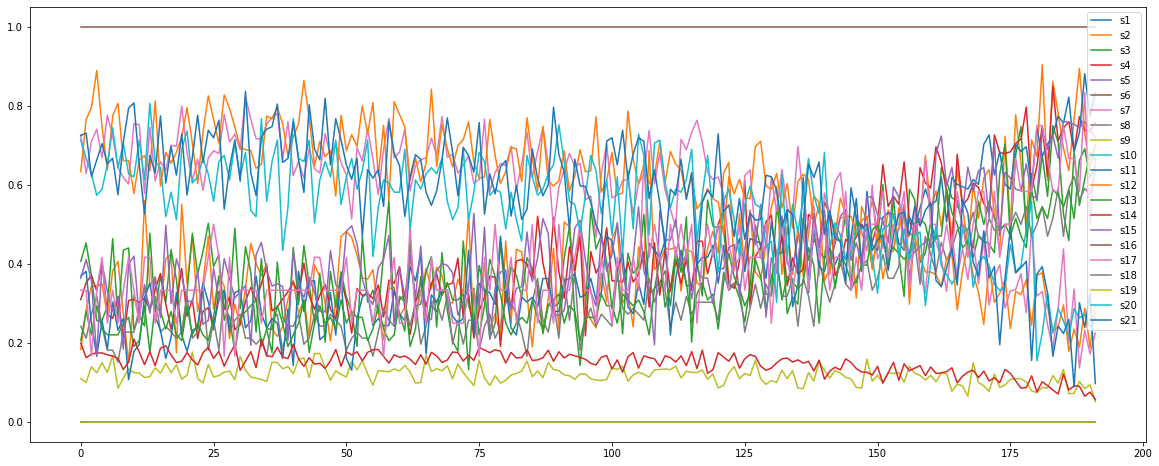

In [ ]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

* Sensor 1 values increase when the cycle of number incrceases.
* Sensor 6 values decrease when the cycle of number increases.
* Most other sensors exhibit either an increasing or decreasing trend.


We can also find other such patterns, which will assist our model in capturing the inherent relationship between the sensor values and the failure point.

Let's plot sensor1 and sensor6 data for two aircraft.

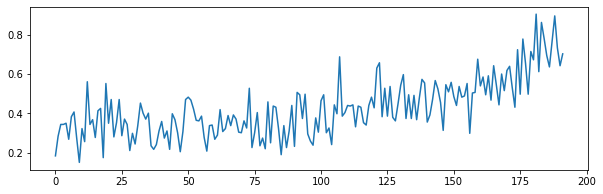

In [ ]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

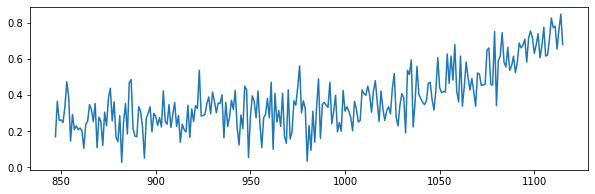

In [ ]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

We have plotted sensor1 observations for id 1 and id 5.

Both observations have an upward trend with increasing cycles.

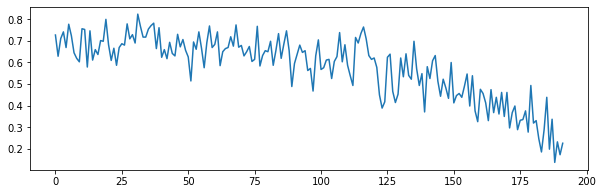

In [ ]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

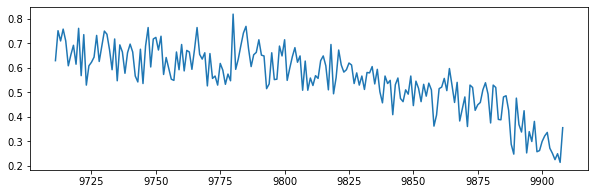

In [ ]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor6 observations for id 1 and id 50.

Both observations have a downward trend with increasing cycles.

We can sew that when the sensor values approach a particular value, the aircraft may fail to work soon.

### Generating Input Sequence

In [ ]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

**Sequence Generator Function**

In [ ]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

**Generating Sequence With Only One Feature "s2"**

In [ ]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"])) #We take only one feature (s2).
           for id in train_df['id'].unique())

# Concatenate the sequences of different engine ids into one array and convert that into a NumPy array
# [(142, 50, 25), ...] --> [(ntotal, 50, 25)].

seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# Let’s print the shape of the seq_set  (number of samples, number of time steps, number of features)
seq_set.shape

(15631, 50, 1)

### Generating Sequence Label (Output)

In [ ]:
# The function to generate labels is as follows:
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # This function will return the following:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # Convert the labels into a NumPy 2D array.

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
        # Remove the first label, as the first prediction will be the (seq_length+1)th label.
    return label_array[seq_length:num_elements, :]

In [ ]:
# Generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1).
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

Let's build our first RNN model using the  [keras API](https://keras.io/api/models/model_training_apis/)

# RNN Models

We will build, train, and evaluate the following models:

* **Simple RNN** [1 Feature]
* **Simple RNN** [25 Features]
* **Bi-Directional RNN** [25 Features]

### Simple RNN [1 Feature]

#### Model Building & Training

In [ ]:
out_dim = label_set.shape[1] # 1 label/output for one sequence.
features_dim = seq_set.shape[2] # Number of features (1)


print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd = Sequential()

# Add the RNN unit.
# Understand the parameters.
RNN_fwd.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=1,
         return_sequences=False))
RNN_fwd.add(Dropout(0.2))

RNN_fwd.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd.summary())

# Define the path to save the model.
RNN_fwd_path = 'RNN_fwd.h5'

Features dimension:  1
Output dimension:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
None


Let's fit the model with a batch size of 200 for 300 epochs. We will save the best model weights using [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) and use [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) to prevent overfitting.

In [ ]:
import time
epochs = 300
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_history = RNN_fwd.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/300
75/75 - 9s - loss: 0.7096 - accuracy: 0.3795 - val_loss: 0.6746 - val_accuracy: 0.8478 - 9s/epoch - 115ms/step
Epoch 2/300
75/75 - 3s - loss: 0.6463 - accuracy: 0.8096 - val_loss: 0.6268 - val_accuracy: 0.8018 - 3s/epoch - 44ms/step
Epoch 3/300
75/75 - 3s - loss: 0.6135 - accuracy: 0.8017 - val_loss: 0.5977 - val_accuracy: 0.8018 - 3s/epoch - 37ms/step
Epoch 4/300
75/75 - 2s - loss: 0.5861 - accuracy: 0.8017 - val_loss: 0.5726 - val_accuracy: 0.8018 - 2s/epoch - 22ms/step
Epoch 5/300
75/75 - 1s - loss: 0.5641 - accuracy: 0.8017 - val_loss: 0.5527 - val_accuracy: 0.8018 - 1s/epoch - 14ms/step
Epoch 6/300
75/75 - 1s - loss: 0.5481 - accuracy: 0.8017 - val_loss: 0.5376 - val_accuracy: 0.8018 - 1s/epoch - 15ms/step
Epoch 7/300
75/75 - 1s - loss: 0.5349 - accuracy: 0.8017 - val_loss: 0.5264 - val_accuracy: 0.8018 - 1s/epoch - 18ms/step
Epoch 8/300
75/75 - 1s - loss: 0.5280 - accuracy: 0.8017 - val_loss: 0.5182 - val_accuracy: 0.8018 - 1s/epoch - 17ms/step
Epoch 9/300
75/75 - 1s 

#### Model Evaluation

**Model Evaluation on the Train and Validation Sets**

In [ ]:
# The function for plotting the change in the model’s accuracy on the train and validation sets is as follows:
def plot_model_accuracy(model_name_history, width = 10, height = 10):

  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['accuracy'])
  plt.plot(model_name_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  fig_acc.savefig("model_accuracy.png")

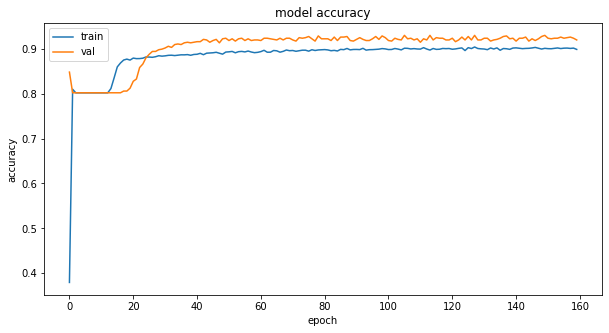

In [ ]:
#Call the function.
plot_model_accuracy(RNN_fwd_history,10,5)

**Training Curve**

In [ ]:
# We will define a function to plot the change in the loss on the train and validation sets.
def plot_training_curve(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['loss'])
  plt.plot(model_name_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  fig_acc.savefig("model_loss.png")

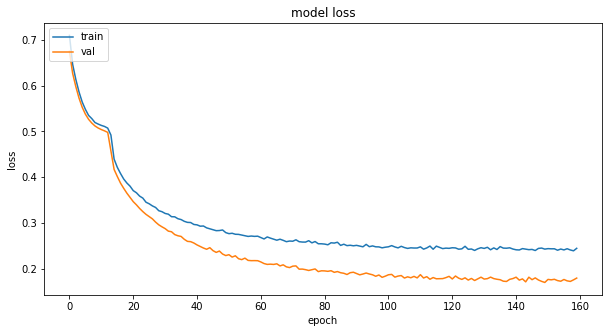

In [ ]:
#Call the function.
plot_training_curve(RNN_fwd_history,10,5)

**Model Evaluation on the Train Set**

In [ ]:
def analyze_model_on_train_set(input_sequence_set, model_name):

  # The training metrics are as follows:
  model_history_scores = model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
  print('Train Accurracy: {}'.format(model_history_scores[1]))

  # Make predictions and compute the confusion matrix.
  y_pred = (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
  y_true = label_set

  test_set = pd.DataFrame(y_pred)
  test_set.to_csv('binary_submit_train.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_cm = confusion_matrix(y_true, y_pred)
  print(model_cm)

  # Compute the precision and recall.
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  print( 'Train Precision = ', model_precision, '\n', 'Train Recall = ', model_recall)

# Call the function.
analyze_model_on_train_set(seq_set, RNN_fwd)

313/313 [==============================] - 1s 4ms/step - loss: 0.1878 - accuracy: 0.9259
Train Accurracy: 0.9259164333343506
79/79 [==============================] - 0s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12247   284]
 [  874  2226]]
Train Precision =  0.8868525896414342 
 Train Recall =  0.7180645161290322


**Model evaluation on test set**

In [ ]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width= 10, height=5):
  # We will consider all the last sequences of the test set.
  last_test_seq = [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:]
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
  last_test_seq = np.asarray(last_test_seq).astype(np.float32)

  # Get the labels of the test set.
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
  last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

  # If the best model weights were saved, load them.
  if os.path.isfile(model_path):
    print("using " + model_path)
    model_estimator = load_model(model_path)

  # Test the metrics.
  start = time.time()
  scores_test = model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
  end = time.time()
  print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

  print('Test Accurracy: {}'.format(scores_test[1]))

  # Make predictions and compute the confusion matrix.
  y_model_estimator_pred_test = (model_estimator.predict(last_test_seq) >0.5).astype("int32")
  y_true_test = last_test_label

  test_set = pd.DataFrame(y_model_estimator_pred_test)
  test_set.to_csv('binary_submit_test.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_estimator_conf_m = confusion_matrix(y_true_test, y_model_estimator_pred_test)
  print(model_estimator_conf_m)

  # Compute the precision and recall values.
  model_estimator_precision_test = precision_score(y_true_test, y_model_estimator_pred_test)
  model_estimator_recall_test = recall_score(y_true_test, y_model_estimator_pred_test)
  f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
  print( 'Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test,'\n', 'Test F1-score:', f1_test )

  # Plot the predicted data in blue and the
  # actual data in green to visually verify the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_model_estimator_pred_test, color="blue")
  plt.plot(y_true_test, color="green")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted', 'actual data'], loc='upper left')
  plt.show()
  fig_verify.savefig("model_verify.png")

using RNN_fwd.h5
3/3 - 0s - loss: 0.2651 - accuracy: 0.9032 - 231ms/epoch - 77ms/step
Total time taken for inferencing:  0.29  secs
Test Accurracy: 0.9032257795333862
3/3 [==============================] - 0s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 8 17]]
Test Precision:  0.9444444444444444 
 Test Recall:  0.68 
 Test F1-score: 0.7906976744186047


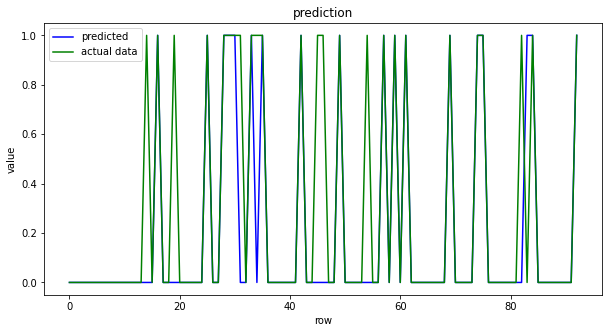

In [ ]:
#Call the function.
analyze_model_on_test_set(["s2"], RNN_fwd_path, 10, 5)

### Simple RNN With 25 Features

Let's now consider data from all 21 sensors and 3 settings as well.
This will lead to 25 features in the input sequence set.

In [ ]:
# Pick the feature columns.
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

#### Generate the Sequence Set

In [ ]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

**The output label will be the same as the previous labels; hence, we do not need to generate it again.**

#### Model Building and Training
Let's define a model to work with the new set of features.
Let's also take more RNN units so it can recognize the combined pattern from all the inputs.


In [ ]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = 'RNN_fwd_2.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50, 5)             155       
                                                                 
 dropout_1 (Dropout)         (None, 50, 5)             0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 3)                 27        
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________
None


Let's fit the model with a batch size of 200 for 200 epochs. We will save the best model weights using [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) and use  [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) to prevent overfitting.

In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 4s - loss: 0.5597 - accuracy: 0.8017 - val_loss: 0.5303 - val_accuracy: 0.8018 - 4s/epoch - 48ms/step
Epoch 2/200
75/75 - 2s - loss: 0.5146 - accuracy: 0.8040 - val_loss: 0.4578 - val_accuracy: 0.8018 - 2s/epoch - 25ms/step
Epoch 3/200
75/75 - 4s - loss: 0.4347 - accuracy: 0.8297 - val_loss: 0.4079 - val_accuracy: 0.8018 - 4s/epoch - 48ms/step
Epoch 4/200
75/75 - 3s - loss: 0.3889 - accuracy: 0.8465 - val_loss: 0.3768 - val_accuracy: 0.8018 - 3s/epoch - 42ms/step
Epoch 5/200
75/75 - 2s - loss: 0.3515 - accuracy: 0.8723 - val_loss: 0.3254 - val_accuracy: 0.8951 - 2s/epoch - 29ms/step
Epoch 6/200
75/75 - 3s - loss: 0.2852 - accuracy: 0.9253 - val_loss: 0.2855 - val_accuracy: 0.9105 - 3s/epoch - 43ms/step
Epoch 7/200
75/75 - 3s - loss: 0.2583 - accuracy: 0.9306 - val_loss: 0.2615 - val_accuracy: 0.9182 - 3s/epoch - 45ms/step
Epoch 8/200
75/75 - 3s - loss: 0.2416 - accuracy: 0.9327 - val_loss: 0.2322 - val_accuracy: 0.9220 - 3s/epoch - 41ms/step
Epoch 9/200
75/75 - 2s -

#### Model Evaluation

**Plot Model Accuracy for the Train and Validation Sets**

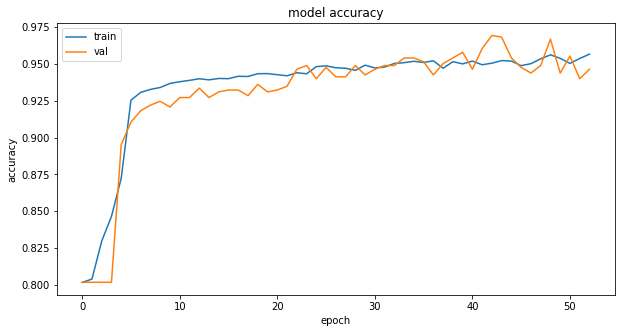

In [ ]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

**Training Curve**

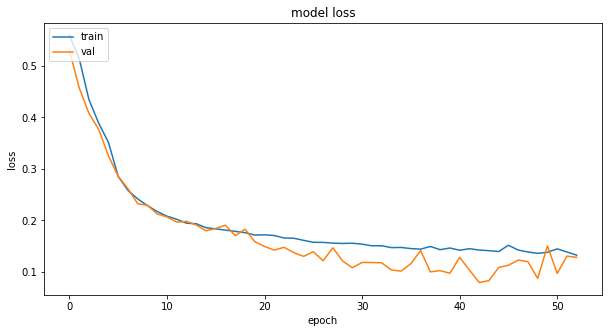

In [ ]:
plot_training_curve(RNN_fwd_2_history,10,5)

**Model Evaluation on Train Set**

In [ ]:
analyze_model_on_train_set(seq_set_f25, RNN_fwd_2)

313/313 [==============================] - 2s 6ms/step - loss: 0.1200 - accuracy: 0.9559
Train Accurracy: 0.955920934677124
79/79 [==============================] - 1s 8ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12455    76]
 [  613  2487]]
Train Precision =  0.9703472493172064 
 Train Recall =  0.802258064516129


**Model Evaluation on Test Set**

using RNN_fwd_2.h5
3/3 - 0s - loss: 0.1790 - accuracy: 0.9462 - 491ms/epoch - 164ms/step
Total time taken for inferencing:  0.54  secs
Test Accurracy: 0.9462365508079529
3/3 [==============================] - 1s 11ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 4 21]]
Test Precision:  0.9545454545454546 
 Test Recall:  0.84 
 Test F1-score: 0.8936170212765958


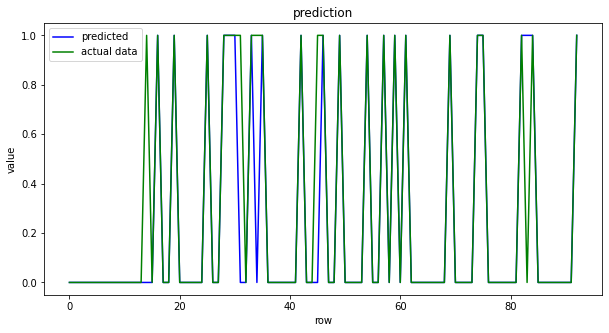

In [ ]:
analyze_model_on_test_set(sequence_cols_25, RNN_fwd_2_path, 10, 5)

###Bidirectional RNN

You saw how to build ForwardRNN models with SimpleRNN units.

Let's now create a bidirectional RNN model.


**The input data will remain the same. We will take all 25 features. Hence, we are not regenerating the input sequence.**

#### Model Building and Training

In [ ]:
#Import a bidirectional library.
from tensorflow.keras.layers import Bidirectional

features_dim = seq_set_f25.shape[2] # Number of features (25)
out_dim = label_set.shape[1] # One output for each sequence (failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_bi = Sequential()

# Understanding return_sequences and the connection across RNN layers
# Note that we have to return the sequence from the first layer so the next layer can get the sequence.

RNN_bi.add(Bidirectional( #We need to pass the RNN unit as an argument of the Bidirectional() function.
         SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=6,
         return_sequences=True)))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the path to save the model.
RNN_bi_path = 'RNN_bi.h5'

Features dimension:  25
Output dimension:  1


Let's fit the model with a batch size of 200 for 200 epochs. We will save the best model weights using [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) and use [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) to prevent overfitting.

In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
RNN_bi_history = RNN_bi.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_bi_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")



Epoch 1/200
75/75 - 13s - loss: 0.5382 - accuracy: 0.7394 - val_loss: 0.3905 - val_accuracy: 0.8056 - 13s/epoch - 167ms/step
Epoch 2/200
75/75 - 10s - loss: 0.3562 - accuracy: 0.8562 - val_loss: 0.2483 - val_accuracy: 0.9169 - 10s/epoch - 131ms/step
Epoch 3/200
75/75 - 7s - loss: 0.2645 - accuracy: 0.9079 - val_loss: 0.2056 - val_accuracy: 0.9322 - 7s/epoch - 99ms/step
Epoch 4/200
75/75 - 8s - loss: 0.2284 - accuracy: 0.9254 - val_loss: 0.1870 - val_accuracy: 0.9322 - 8s/epoch - 101ms/step
Epoch 5/200
75/75 - 8s - loss: 0.2067 - accuracy: 0.9298 - val_loss: 0.1704 - val_accuracy: 0.9361 - 8s/epoch - 101ms/step
Epoch 6/200
75/75 - 8s - loss: 0.1960 - accuracy: 0.9339 - val_loss: 0.1696 - val_accuracy: 0.9386 - 8s/epoch - 104ms/step
Epoch 7/200
75/75 - 7s - loss: 0.1907 - accuracy: 0.9357 - val_loss: 0.1568 - val_accuracy: 0.9437 - 7s/epoch - 99ms/step
Epoch 8/200
75/75 - 14s - loss: 0.1836 - accuracy: 0.9351 - val_loss: 0.1526 - val_accuracy: 0.9450 - 14s/epoch - 186ms/step
Epoch 9/200


In [ ]:
#Print the summary of the model.
print(RNN_bi.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 50, 12)           384       
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 12)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 3)                 48        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 436
Trainable params: 436
Non-trainable params: 0
__________________________________________________________

#### Model Evaluation

**Plot model accuracy for train and validation set**

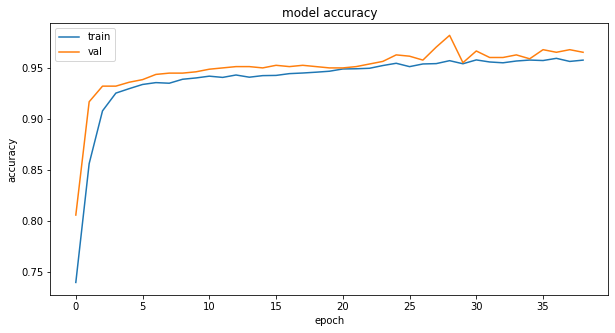

In [ ]:
plot_model_accuracy(RNN_bi_history,10,5)

**Training curve**

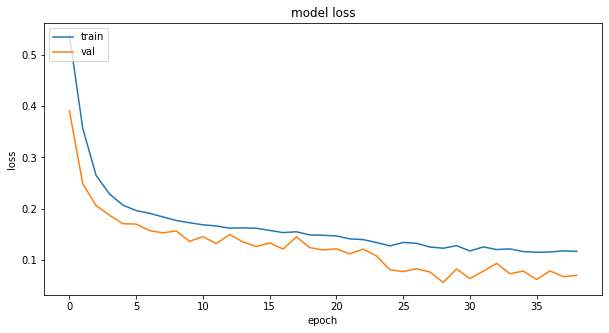

In [ ]:
plot_training_curve(RNN_bi_history,10,5)

**Model Evaluation on train set**

In [ ]:
analyze_model_on_train_set(seq_set_f25, RNN_bi)

313/313 [==============================] - 4s 13ms/step - loss: 0.0842 - accuracy: 0.9666
Train Accurracy: 0.9666048288345337
79/79 [==============================] - 1s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12353   178]
 [  344  2756]]
Train Precision =  0.9393319700068167 
 Train Recall =  0.8890322580645161


**Model Evaluation on test set**

using RNN_bi.h5
3/3 - 1s - loss: 0.0913 - accuracy: 0.9570 - 583ms/epoch - 194ms/step
Total time taken for inferencing:  0.63  secs
Test Accurracy: 0.9569892287254333
3/3 [==============================] - 0s 18ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 2 23]]
Test Precision:  0.92 
 Test Recall:  0.92 
 Test F1-score: 0.92


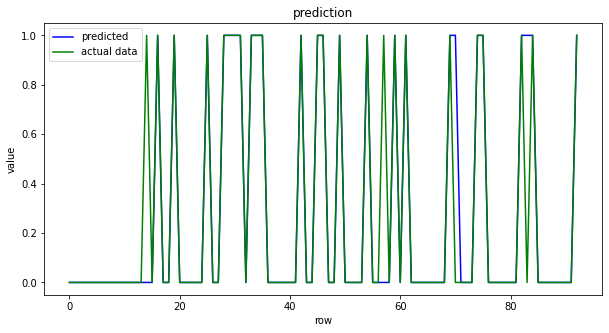

In [ ]:
analyze_model_on_test_set(sequence_cols_25, RNN_bi_path,10,5)

### RNN Summary
1. The performance of the RNN with one feature on the test set is worse than that of a more complex RNN.
2. RNN model with increased units with all 25 features achieves better accuracy and other evaluation metrics
3. When we use more than one layer, the previous layer must be set to return_sequences = True.



# References


- [1] Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- [2] Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
- [3] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA
- [4] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/

